In [ ]:
import os
os.chdir('../')

In [8]:
import scanpy as sc
import numpy as np
import pandas as pd

adata_list=[[],[],[]]
adata_list[0].append(sc.read_h5ad("dataset/SRT_data/151507_adata.h5ad"))
adata_list[0].append(sc.read_h5ad("dataset/SRT_data/151508_adata.h5ad"))
adata_list[0].append(sc.read_h5ad("dataset/SRT_data/151509_adata.h5ad"))
adata_list[0].append(sc.read_h5ad("dataset/SRT_data/151510_adata.h5ad"))

adata_list[1].append(sc.read_h5ad("dataset/SRT_data/151669_adata.h5ad"))
adata_list[1].append(sc.read_h5ad("dataset/SRT_data/151670_adata.h5ad"))
adata_list[1].append(sc.read_h5ad("dataset/SRT_data/151671_adata.h5ad"))
adata_list[1].append(sc.read_h5ad("dataset/SRT_data/151672_adata.h5ad"))

adata_list[2].append(sc.read_h5ad("dataset/SRT_data/151673_adata.h5ad"))
adata_list[2].append(sc.read_h5ad("dataset/SRT_data/151674_adata.h5ad"))
adata_list[2].append(sc.read_h5ad("dataset/SRT_data/151675_adata.h5ad"))
adata_list[2].append(sc.read_h5ad("dataset/SRT_data/151676_adata.h5ad"))

sc_adata = sc.read_h5ad("dataset/SC_data/scref_adata.h5ad")

In [9]:
import os
from R_initialization import FUSION_Init

R_HOME='/public/home/dongqishi/miniconda3/envs/gpu/lib/R'
R_USER='/public/home/dongqishi/miniconda3/envs/gpu/site-packages/rpy2'

domain_size=7

FUSION_Init(adata_list, sc_adata,domain_size, R_HOME, R_USER)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In .recacheSubclasses(def@className, def, env) :
R[write to console]: 
 
R[write to console]:  undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated



Section0 initialization complete
Section1 initialization complete
Section2 initialization complete


In [11]:
from main_ref import FUSION_preprocess

seed=123

log_fc_cut=1.5

FUSION_preprocess(adata_list, log_fc_cut, seed)

Total slice loaded: 3
RangeIndex(start=0, stop=18026, step=1)
Batch merging complete
parition complete
        start_idx  end_idx
origin                    
batch1          0     4225
batch2       4225     8607
batch3       8607    13394
batch4      13394    18026
RangeIndex(start=0, stop=15281, step=1)
Batch merging complete
parition complete
        start_idx  end_idx
origin                    
batch1          0     3660
batch2       3660     7157
batch3       7157    11266
batch4      11266    15281
RangeIndex(start=0, stop=14364, step=1)
Batch merging complete
parition complete
        start_idx  end_idx
origin                    
batch1          0     3639
batch2       3639     7312
batch3       7312    10904
batch4      10904    14364
preprocess complete


In [16]:
import torch 
device = torch.device('cuda:1' if torch.cuda.device_count() > 0 else 'cpu')
print(f'Training on: {device}')

         
from main_ref import FUSION_main

seed=123

embed_dim=50

alpha,beta=0.1,1

out, embeddings = FUSION_main(adata_list, embed_dim, domain_size, [[alpha,beta]]*len(adata_list), False, device, seed)

Training on: cuda:1


100%|██████████| 50/50 [00:03<00:00, 15.78it/s]


Detected Domain Size across Slices:[7, 7, 7, 7]


100%|██████████| 50/50 [00:02<00:00, 20.83it/s]


Detected Domain Size across Slices:[6, 6, 6, 6]


100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


Detected Domain Size across Slices:[7, 7, 7, 7]


In [18]:
from r_batch import FUSION_correction

refined_embed= FUSION_correction(adata_list, embeddings, seed)

/public/home/dongqishi/miniconda3/envs/MS/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/public/home/dongqishi/miniconda3/envs/MS/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/public/home/dongqishi/miniconda3/envs/MS/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ARI of joint section analysis:0.650415808485908
ARI of joint section analysis:0.6941813776645238
ARI of joint section analysis:0.5356901230779394
ARI of joint section analysis:0.644574230500107


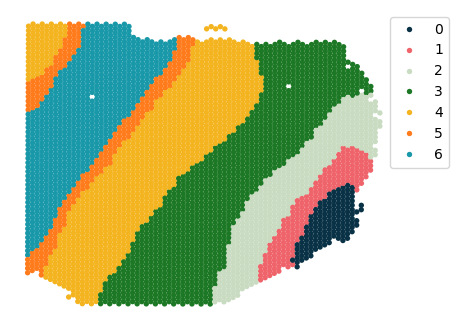

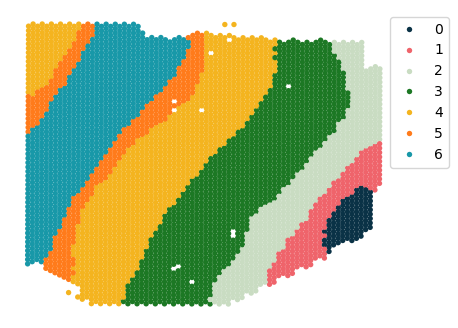

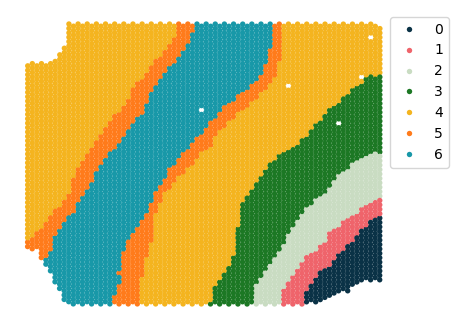

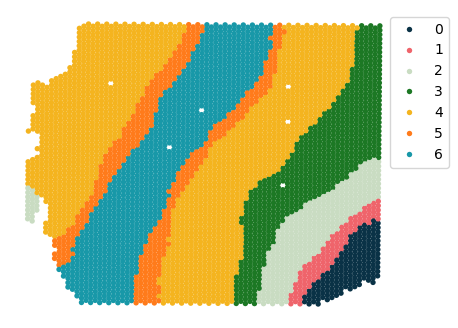

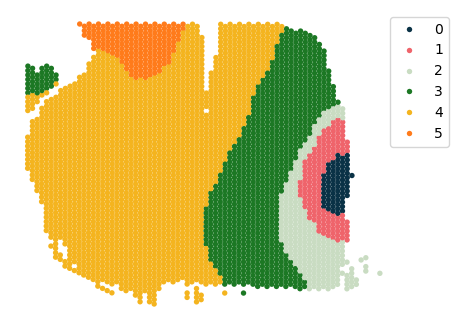

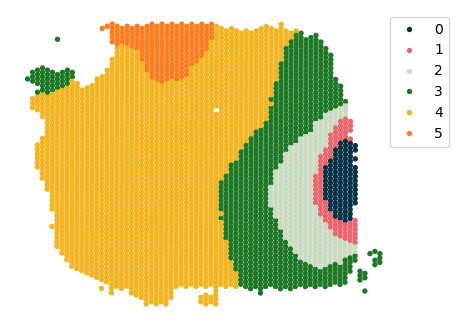

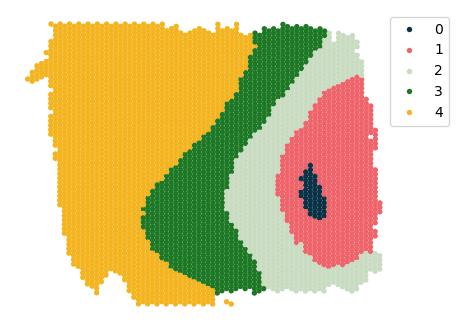

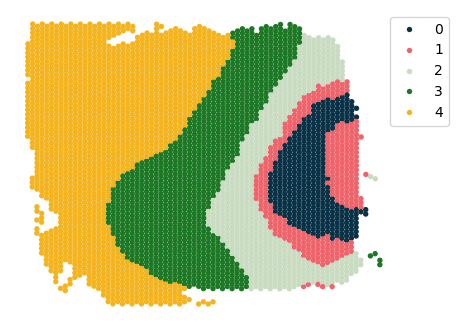

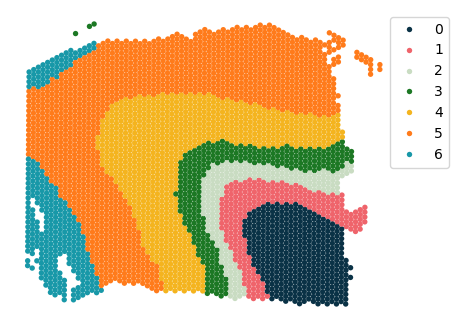

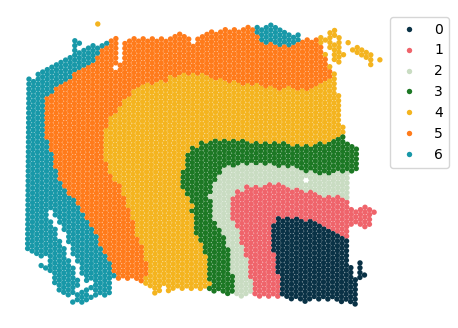

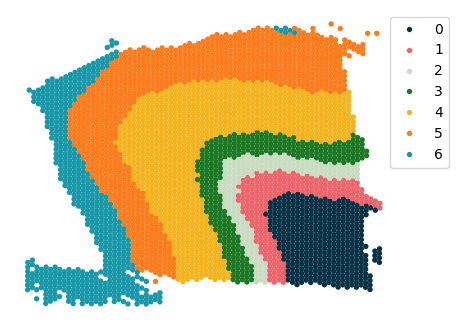

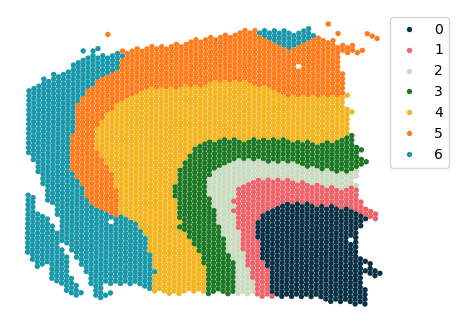

In [17]:
from utils import section_alignment, domain_plot
import pickle
from sklearn.metrics.cluster import adjusted_rand_score

out= section_alignment(out, method='Distance')

ARI_tmp=[]
truth_list=[]

for i in range(3):
    
    with open('dataset/SRT_data/truth_list_DLPFC{}.pkl'.format(4*(i+1)), 'rb') as f:
        truth = pickle.load(f)
    
    truth_list.append(truth)
        
    for j in range(4):
    
        combined_array = out [i][out [i]['slide']==j].loc[:,['domain','x','y']]

        combined_array.columns=['est_do', 'imagerow', 'imagecol']

        combined_array = np.hstack((combined_array['est_do'].values.reshape(-1,1), truth[j].reshape(-1,1)))

        ARI_tmp.append(combined_array)

ARI=[]
for res in ARI_tmp:
    ARI.append(adjusted_rand_score(res[:,1],res[:,0]))

print('ARI of joint section analysis:{}'.format(np.median(ARI[0:4])))
print('ARI of joint section analysis:{}'.format(np.median(ARI[4:8])))
print('ARI of joint section analysis:{}'.format(np.median(ARI[8:12])))
print('ARI of joint section analysis:{}'.format(np.median(ARI[0:12])))

color_dict={1:(239,100,107), 0:(10,50,70),5:(255,123,27),4:(244,180,31),3:(28,120,36),6:(24,152,168),2:(201,220,194)}

cell_size=15

for i in range(3):
    for j in range(4):
        c_slide=out[i][out[i]['slide']==j]
        domain_plot(c_slide['domain'].values,c_slide[['x','y']].values,color_dict, cell_size, (5,4))

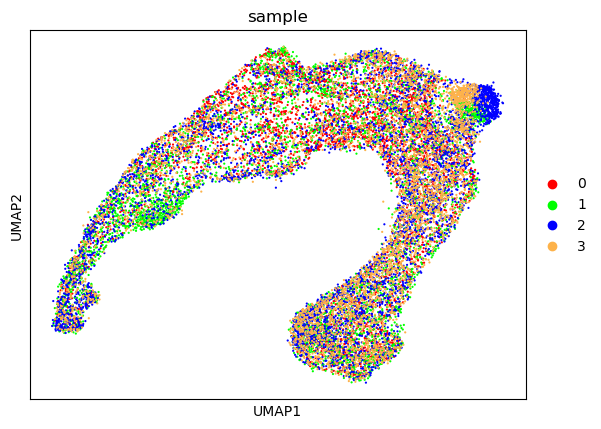

Mean iLISI: 3.23


In [30]:
from utils import compute_lisi
def list2df(list_of_lists1, list_of_lists2):

    # Create a list to store the data for the DataFrame
    data = []

    # Loop through the list of lists
    for idx, sublist in enumerate(list_of_lists1):
        for idx_2,label in enumerate(sublist):
            data.append({'domain': label, 'truth':list_of_lists2[idx][idx_2],'sample': idx})
    

    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    
    df['domain'] = df['domain'].astype('category')
    df['sample'] = df['sample'].astype('category')
    df['truth'] = df['truth'].astype('category')
    
    return df


custom_colors =  [
    (255, 0, 0),       # Red
    (0, 255, 0),       # Green
    (0, 0, 255),       # Blue
    (253,178,74)
]

normalized_colors = [(r/255, g/255, b/255) for r, g, b in custom_colors]

adata_batch= sc.AnnData(np.vstack(refined_embed[0]))
adata_batch.obs=list2df([out[0]['domain'][out[0]['slide']==i].values for i in range(4)], [truth_list[0][i] for i in range(4)])

sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch, min_dist=0.5,init_pos='spectral',random_state=123)             # Compute UMAP
sc.pl.umap(adata_batch, color='sample', palette=normalized_colors, size=10.0)

embedding = adata_batch.obsm['X_umap']
dataset_labels = adata_batch.obs['sample'].values
ilisi_scores = compute_lisi(embedding, dataset_labels, k=30)
print(f"Mean iLISI: {np.mean(ilisi_scores):.2f}")# Compute UMAP